In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import h5py

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, minmax_scale, robust_scale

import scipy.ndimage
from scipy import interpolate
from scipy.stats import gmean, hmean

In [2]:
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [3]:
def interp_wn(old_tab, old_wn, new_wn):

    new_tab = np.zeros((old_tab.shape[0], len(new_wn)))

    for i in range(old_tab.shape[0]):

        new_tab[i,:] = interpolate.interp1d(old_wn, old_tab[i,:], bounds_error=False)(new_wn)

    return new_tab

In [4]:

with h5py.File('/mnt/c/Users/conor/Google Drive/PhD/Core4_Upsample.mat', 'r') as f:
    print(f.keys())

    core = 1-np.array(f['Core4_Area1'])
    ir = np.array(f['IR_Area1'])
    wns = np.array(f['wn1'])

<KeysViewHDF5 ['Core4_Area1', 'IR_Area1', 'wn1']>


In [5]:
with h5py.File('/mnt/c/Users/conor/Google Drive/PhD/G9_Area1.mat', 'r') as f:
    print(f.keys())

    core2 = 1-np.array(f['I_G9_AREA3'])
    ir2 = np.array(f['G9_IR_Area1'])
    wns2 = np.array(f['wn2'])

new_tab = interp_wn(ir2.T.reshape(-1, wns2.shape[1]), wns2.squeeze(), wns.squeeze())

ir2 = new_tab.T.reshape((-1,)+ir2.shape[1:],order='F')

<KeysViewHDF5 ['G9_IR_Area1', 'I_G9_AREA3', 'wn2']>


In [6]:
scaler = RobustScaler()

#x_train = scaler.fit_transform(ir.T.reshape(-1, wns.shape[1]))
#x_test = scaler.fit_transform(ir2.T.reshape(-1, wns.shape[1]))

#joined = np.concatenate([im.T.reshape(-1, wns.shape[1]) for im in [ir, ir2]])

x_train, x_test = train_test_split(ir.T.reshape(-1, wns.shape[1]), shuffle=True)
#x_train, x_test = train_test_split(joined, shuffle=True)

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [8]:
latent_dim = 32

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Input(x_train.shape[1]),
      layers.Flatten(),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(x_train.shape[1])
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [9]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [10]:
history = autoencoder.fit(x_train, x_train,
                epochs=5,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/5
15258/15258 [==============================] - 70s 5ms/step - loss: 7.4179e-04 - val_loss: 2.1302e-04
Epoch 2/5
15258/15258 [==============================] - 73s 5ms/step - loss: 1.0199e-04 - val_loss: 5.5220e-05
Epoch 3/5
15258/15258 [==============================] - 81s 5ms/step - loss: 7.2260e-05 - val_loss: 6.2841e-05
Epoch 4/5
15258/15258 [==============================] - 79s 5ms/step - loss: 5.8614e-05 - val_loss: 7.8828e-05
Epoch 5/5
15258/15258 [==============================] - 94s 6ms/step - loss: 4.8702e-05 - val_loss: 2.6519e-05


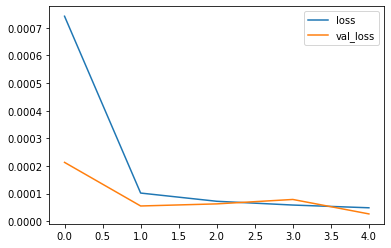

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [95]:
encoded = autoencoder.encoder(scaler.transform(ir.T.reshape(-1, wns.shape[1]))).numpy()
#encoded = autoencoder.encoder(ir.T.reshape(-1, wns.shape[1])).numpy()

mx = np.argmax(encoded.mean(axis=0))

core_scaled = minmax_scale(core.T.reshape(-1,1), feature_range=(np.quantile(encoded,.05), np.quantile(encoded,.95)))
#core_scaled = minmax_scale(core.T.reshape(-1,1), feature_range=(encoded[:,].min(), encoded[:,0].max()))

#stacked = np.concatenate([core_scaled.T.reshape(-1,1), encoded[:,1:]], axis=1)
stacked = encoded.copy()
stacked[:,mx] = core_scaled.squeeze()
#stacked = encoded

#---------
stacked = np.zeros(encoded.shape)

for i in range(latent_dim):

    #stacked[:,i] = np.mean([core_scaled.squeeze(), encoded[:,i]],axis=0)
    stacked[:,i] = gmean([core_scaled.squeeze(), encoded[:,i]],axis=0)
    #stacked[:,i] = stacked[:,i] - encoded.mean()
    #stacked[:,i] = encoded[:,i]/core_scaled.squeeze()

#stacked = stacked - stacked.mean()
#--------

mapped = autoencoder.decoder(stacked).numpy()
up_scaled = mapped.reshape(ir.T.shape)

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/scipy/stats/stats.py:402: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


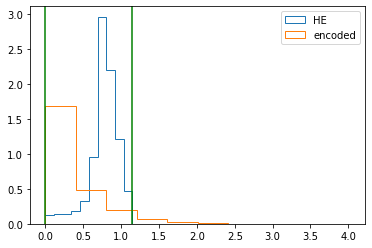

In [96]:
plt.hist(core_scaled, label='HE', histtype='step', density=True)
plt.hist(encoded.flatten(), label='encoded', histtype='step', density=True)
plt.axvline(np.quantile(encoded,.05), c='g')
plt.axvline(np.quantile(encoded,.95), c='g')
plt.legend()

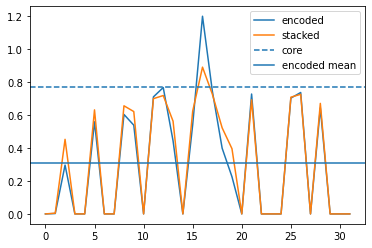

In [97]:
plt.plot(encoded.mean(axis=0), label='encoded')
plt.plot(stacked.mean(axis=0), label='stacked')
plt.axhline(core_scaled.mean(axis=0), label='core', ls='--')
plt.axhline(encoded.mean(), label='encoded mean')
plt.legend()

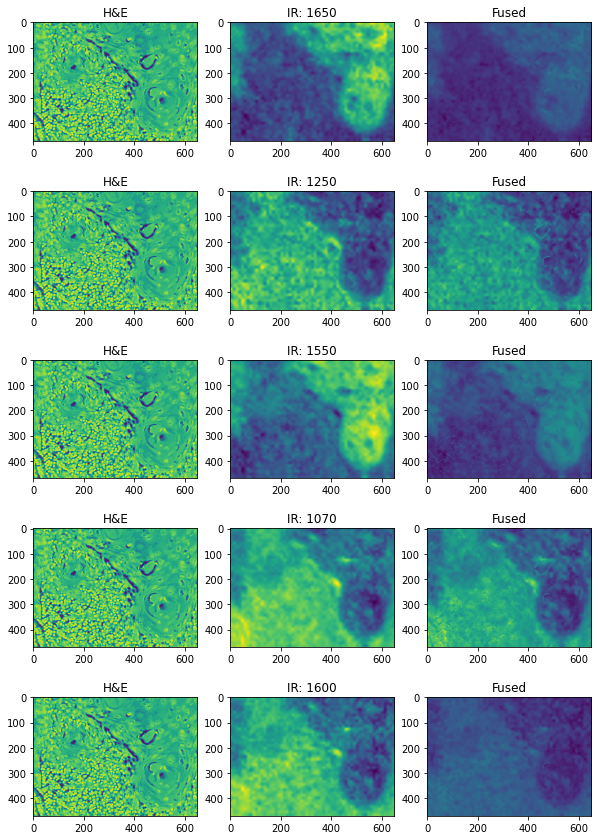

In [98]:
wns_ = [1650, 1250, 1550, 1070, 1600]

fig, rows = plt.subplots(figsize=(10, 3*len(wns_)), ncols = 3, nrows = len(wns_))

for wn, cols in zip(wns_, rows):

    wni = np.argmin([np.abs(wn - i) for i in wns.squeeze()])

    for title, col, im in zip(['H&E',f'IR: {wn}','Fused'], cols, [core.T, ir[wni,:,:].T, up_scaled[:,:,wni]]):

        col.set_title(title)
        col.imshow(im)

fig.savefig('./Fusion_Results.pdf')

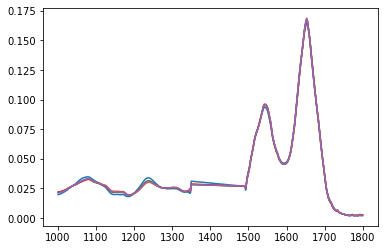

In [99]:
for i in np.random.randint(0,7000,5):
    
    plt.plot(wns.squeeze(), scaler.inverse_transform(mapped)[i, :].T)

In [71]:
def interp_wn(old_tab, old_wn, new_wn):

    new_tab = np.zeros((old_tab.shape[0], len(new_wn)))

    for i in range(old_tab.shape[0]):

        new_tab[i,:] = interpolate.interp1d(old_wn, old_tab[i,:], bounds_error=False)(new_wn)

    return new_tab

In [72]:
encoded = autoencoder.encoder(scaler.transform(ir2.T.reshape(-1, wns.shape[1]))).numpy()
#encoded = autoencoder.encoder(ir.T.reshape(-1, wns.shape[1])).numpy()

mx = np.argmax(encoded.mean(axis=0))

core_scaled = minmax_scale(core2.T.reshape(-1,1), feature_range=(np.quantile(encoded[:,mx],.01), np.quantile(encoded[:,mx],.99)))
#core_scaled = minmax_scale(core.T.reshape(-1,1), feature_range=(encoded[:,].min(), encoded[:,0].max()))

#stacked = np.concatenate([core_scaled.T.reshape(-1,1), encoded[:,1:]], axis=1)
stacked = encoded.copy()
stacked[:,mx] = core_scaled.squeeze()
#stacked = encoded

mapped = autoencoder.decoder(stacked).numpy()
up_scaled = mapped.reshape(ir2.T.shape)

In [73]:
encoded = autoencoder.encoder(scaler.transform(ir2.T.reshape(-1, wns.shape[1]))).numpy()
#encoded = autoencoder.encoder(ir.T.reshape(-1, wns.shape[1])).numpy()

mx = np.argmax(encoded.mean(axis=0))

core_scaled = minmax_scale(core2.T.reshape(-1,1), feature_range=(np.quantile(encoded[:,mx],.01), np.quantile(encoded[:,mx],.99)))
#core_scaled = minmax_scale(core.T.reshape(-1,1), feature_range=(encoded[:,].min(), encoded[:,0].max()))

#stacked = np.concatenate([core_scaled.T.reshape(-1,1), encoded[:,1:]], axis=1)
stacked = encoded.copy()
stacked[:,mx] = core_scaled.squeeze()
#stacked = encoded

#---------
stacked = np.zeros(encoded.shape)

for i in range(latent_dim):

    #stacked[:,i] = np.mean([core_scaled.squeeze(), encoded[:,i]],axis=0)
    stacked[:,i] = gmean([core_scaled.squeeze(), encoded[:,i]],axis=0)

stacked = stacked - stacked.mean()
#--------

mapped = autoencoder.decoder(stacked).numpy()
up_scaled = mapped.reshape(ir2.T.shape)

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/scipy/stats/stats.py:402: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


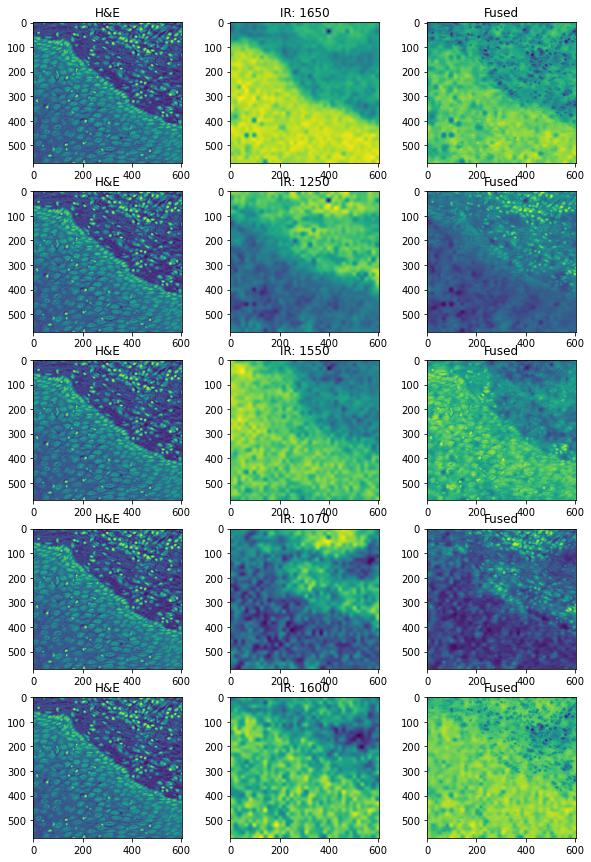

In [89]:
wns_ = [1650, 1250, 1550, 1070, 1600]

fig, rows = plt.subplots(figsize=(10, 3*len(wns_)), ncols = 3, nrows = len(wns_))

for wn, cols in zip(wns_, rows):

    wni = np.argmin([np.abs(wn - i) for i in wns.squeeze()])

    for title, col, im in zip(['H&E',f'IR: {wn}','Fused'], cols, [core2.T, ir2[wni,:,:].T, up_scaled[:,:,wni]]):
        
        col.set_title(title)
        col.imshow(im)

fig.savefig('./Fusion_Results2.pdf')

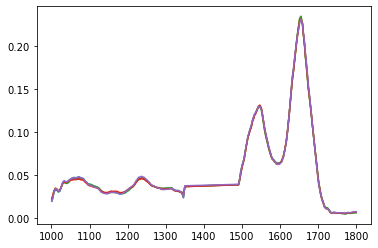

In [75]:
for i in np.random.randint(0,7000,5):
    
    plt.plot(wns.squeeze(), scaler.inverse_transform(mapped)[i, :].T)